In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210611'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01,  9.94it/s]


(636850, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(634283, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '양천구'
target_dong = '목동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 36 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(696, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
199815,서울특별시 양천구 목동 318-239,목동중앙본로11길 21,더하우스,54.12,37.73,34500,5,2021.0,0.0,2021-02-01,637.472284,0.0,연립다세대,대,245.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),양천구,목동
199816,서울특별시 양천구 목동 318-239,목동중앙본로11길 21,더하우스,29.96,20.89,27900,2,2021.0,0.0,2021-05-05,931.241656,0.0,연립다세대,대,245.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),양천구,목동
199817,서울특별시 양천구 목동 318-239,목동중앙본로11길 21,더하우스,29.74,20.73,27900,2,2021.0,0.0,2021-05-17,938.130464,0.0,연립다세대,대,245.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),양천구,목동
200254,서울특별시 양천구 목동 537-31,목동중앙북로16가길 27,목동숲아파트,27.40,20.11,26000,5,2017.0,1.0,2018-08-22,948.905109,4.0,연립다세대,대,171.7,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,양천구,목동
200255,서울특별시 양천구 목동 537-31,목동중앙북로16가길 27,목동숲아파트,29.88,20.72,22800,2,2017.0,2.0,2019-12-20,763.052209,4.0,연립다세대,대,171.7,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,양천구,목동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(696, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
199815,서울특별시 양천구 목동 318-239,목동중앙본로11길 21,더하우스,54.12,37.73,34500,5,2021.0,0.0,2021-02-01,637.472284,0.0,연립다세대,대,245.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),양천구,목동,644.497507,2021-03-01
199816,서울특별시 양천구 목동 318-239,목동중앙본로11길 21,더하우스,29.96,20.89,27900,2,2021.0,0.0,2021-05-05,931.241656,0.0,연립다세대,대,245.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),양천구,목동,931.241656,2021-05-05
199817,서울특별시 양천구 목동 318-239,목동중앙본로11길 21,더하우스,29.74,20.73,27900,2,2021.0,0.0,2021-05-17,938.130464,0.0,연립다세대,대,245.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),양천구,목동,938.130464,2021-05-17
200254,서울특별시 양천구 목동 537-31,목동중앙북로16가길 27,목동숲아파트,27.40,20.11,26000,5,2017.0,1.0,2018-08-22,948.905109,4.0,연립다세대,대,171.7,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,양천구,목동,1128.672949,2021-03-01
200255,서울특별시 양천구 목동 537-31,목동중앙북로16가길 27,목동숲아파트,29.88,20.72,22800,2,2017.0,2.0,2019-12-20,763.052209,4.0,연립다세대,대,171.7,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,양천구,목동,866.272402,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 양천구 목동 124-11,일주하우스,3.0,29.66,2018-11-26,26300,886.716116,2021-03-01,1060.340152,제2종일반주거지역,연립다세대
1,서울특별시 양천구 목동 124-11,일주하우스,3.0,29.14,2020-03-04,26900,923.129719,2021-03-01,1043.069261,제2종일반주거지역,연립다세대
2,서울특별시 양천구 목동 124-11,일주하우스,3.0,29.14,2020-03-04,27000,926.561428,2021-03-01,1046.946842,제2종일반주거지역,연립다세대
3,서울특별시 양천구 목동 124-11,일주하우스,3.0,29.14,2020-05-21,27800,954.015100,2021-03-01,1067.044382,제2종일반주거지역,연립다세대
4,서울특별시 양천구 목동 124-11,일주하우스,3.0,29.39,2020-08-06,29000,986.730180,2021-03-01,1060.409008,제2종일반주거지역,연립다세대


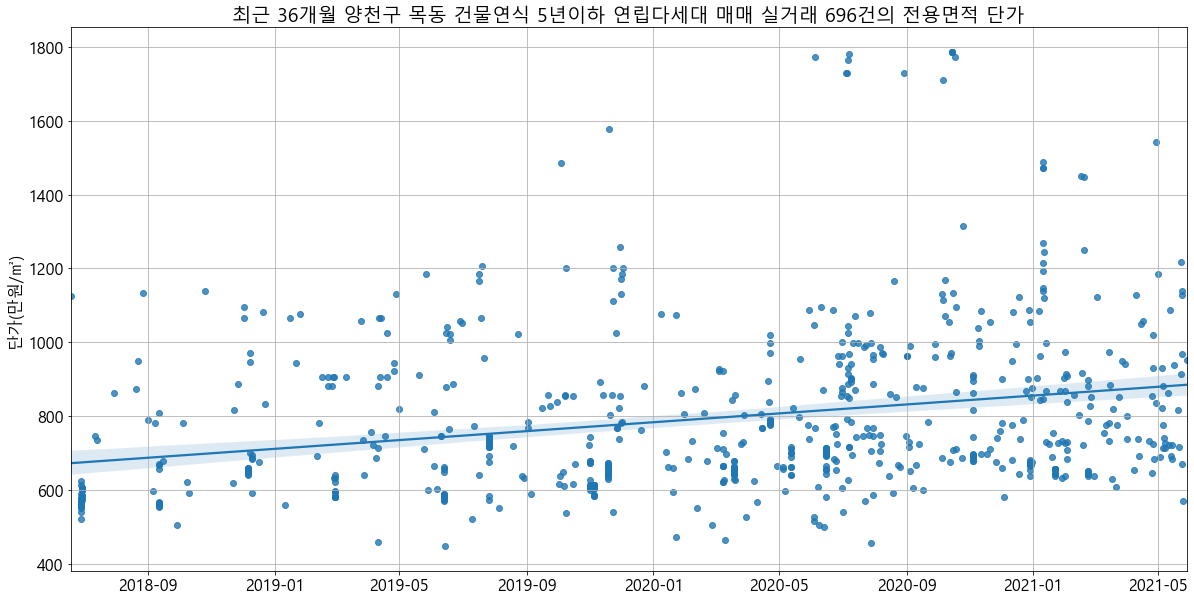

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

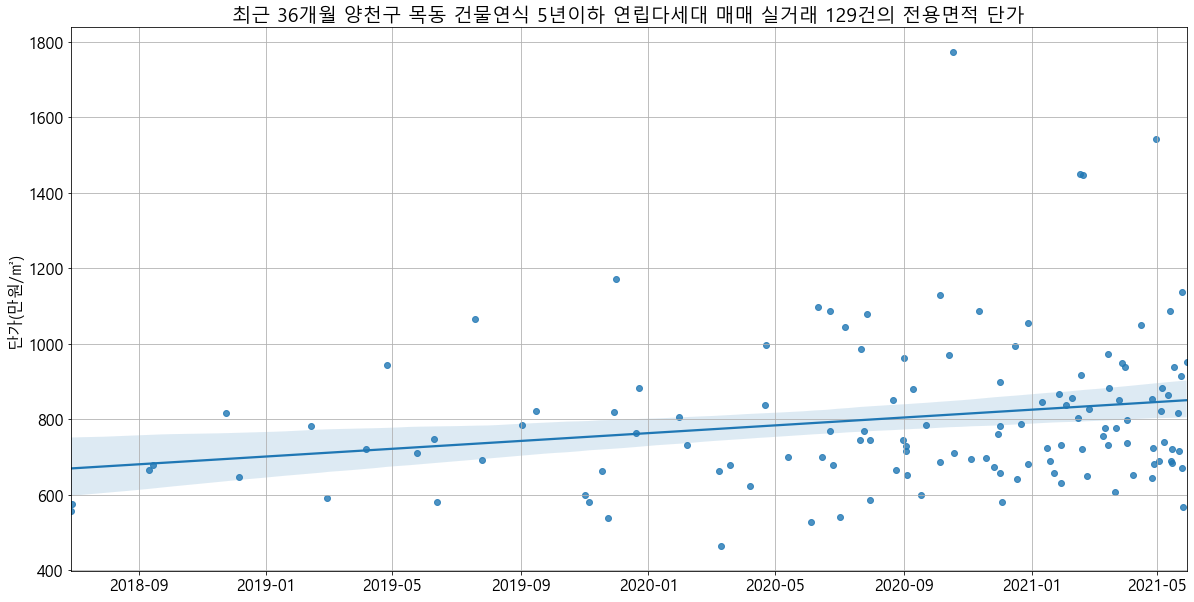

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(5088, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
199758,서울특별시 양천구 목동 128-4,목동중앙로13나길 25,(128-4),36.84,25.07,11000,2,2003.0,3.0,2006-12-06,298.588491,18.0,연립다세대,대,208.0,제2종일반주거지역,지정되지않음,주상용,평지,세로장방,소로각지,양천구,목동
199759,서울특별시 양천구 목동 128-4,목동중앙로13나길 25,(128-4),57.35,39.02,14000,2,2003.0,3.0,2006-12-06,244.115083,18.0,연립다세대,대,208.0,제2종일반주거지역,지정되지않음,주상용,평지,세로장방,소로각지,양천구,목동
199760,서울특별시 양천구 목동 128-4,목동중앙로13나길 25,(128-4),36.84,25.07,11500,2,2003.0,4.0,2007-10-27,312.160695,18.0,연립다세대,대,208.0,제2종일반주거지역,지정되지않음,주상용,평지,세로장방,소로각지,양천구,목동
199761,서울특별시 양천구 목동 128-4,목동중앙로13나길 25,(128-4),57.35,39.02,15000,2,2003.0,5.0,2008-07-21,261.551874,18.0,연립다세대,대,208.0,제2종일반주거지역,지정되지않음,주상용,평지,세로장방,소로각지,양천구,목동
199795,서울특별시 양천구 목동 318-235,목동중앙본로11길 15,(318-235),71.04,38.50,11500,4,2003.0,3.0,2006-03-30,161.880631,18.0,연립다세대,대,155.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),양천구,목동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'양천구 목동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 5088건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

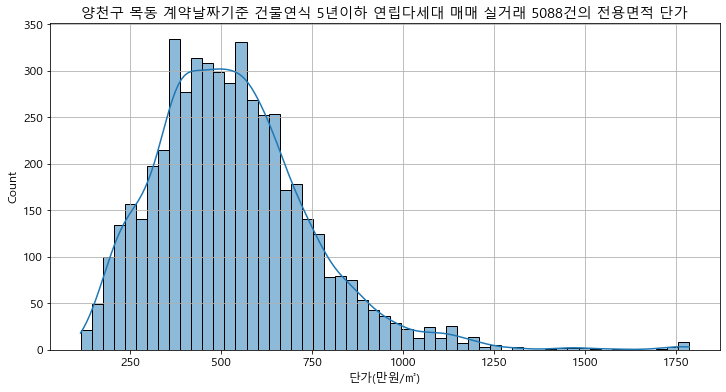

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(2614, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 양천구 목동 124-10,목동중앙로13길 45-5,에스엘파크뷰,17.88,12.56,15550,4,2015.0,5.0,2020-07-06,869.686801,6.0,연립다세대,대,201.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,934.818154,2021-03-01,754.673156,801.993582
1,서울특별시 양천구 목동 124-10,목동중앙로13길 45-5,에스엘파크뷰,20.25,12.56,17040,4,2015.0,5.0,2020-10-23,841.481481,6.0,연립다세대,대,201.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,887.205795,2021-03-01,754.673156,801.993582
2,서울특별시 양천구 목동 124-10,목동중앙로13길 45-5,에스엘파크뷰,21.52,11.90,14500,4,2015.0,5.0,2020-10-25,673.791822,6.0,연립다세대,대,201.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,710.404236,2021-03-01,754.673156,801.993582
3,서울특별시 양천구 목동 124-10,목동중앙로13길 45-5,에스엘파크뷰,22.11,11.90,13000,2,2015.0,5.0,2020-06-03,587.969245,6.0,연립다세대,대,201.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,639.922369,2021-03-01,754.673156,801.993582
4,서울특별시 양천구 목동 124-10,목동중앙로13길 45-5,에스엘파크뷰,29.92,20.83,26940,2,2015.0,5.0,2020-10-16,900.401070,6.0,연립다세대,대,201.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,949.326948,2021-03-01,754.673156,801.993582


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(901, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
5,서울특별시 양천구 목동 124-10,목동중앙로13길 45-5,에스엘파크뷰,42.37,21.49,27740,2,2015.0,5.0,2020-10-22,654.708520,6.0,연립다세대,대,201.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,690.283988,2021-03-01,754.673156,801.993582
9,서울특별시 양천구 목동 124-11,목동중앙로13길 37-8,일주하우스,29.66,20.95,26300,3,2018.0,0.0,2018-11-26,886.716116,3.0,연립다세대,대,200.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),양천구,목동,1060.340152,2021-03-01,1050.303734,1131.970025
15,서울특별시 양천구 목동 124-15,목동중앙로13길 37-6,화이트빌,60.42,32.00,25000,2,2002.0,4.0,2006-11-24,413.770275,19.0,연립다세대,대,197.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,804.957034,2021-03-01,451.568632,851.672399
18,서울특별시 양천구 목동 124-18,목동중앙로13길 37,아줄리움,31.56,18.86,22000,3,2014.0,4.0,2018-11-28,697.084918,7.0,연립다세대,대,208.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로각지(가),양천구,목동,833.578091,2021-03-01,788.808196,915.654476
24,서울특별시 양천구 목동 124-19,목동중앙로13길 37-5,목동리치하우스,42.37,24.95,25000,4,2012.0,0.0,2012-11-11,590.040123,9.0,연립다세대,대,198.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),양천구,목동,865.785402,2021-03-01,529.804160,754.564165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,서울특별시 양천구 목동 805-19,목동중앙서로6길 26,목동서진플로렌스805,53.30,30.74,30000,5,2014.0,3.0,2017-07-22,562.851782,7.0,연립다세대,대,177.0,제2종일반주거지역,지정되지않음,주거기타,평지,사다리형,세로한면(가),양천구,목동,706.137467,2021-03-01,629.623754,820.125672
2604,서울특별시 양천구 목동 805-7,목동중앙서로6길 20-25,해바라기빌라(805-7),54.29,35.22,23700,4,2003.0,3.0,2006-09-07,436.544483,18.0,연립다세대,대,376.8,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(불),양천구,목동,923.331017,2021-03-01,447.208185,741.200252
2606,서울특별시 양천구 목동 805-9,목동중앙서로6길 20-21,대양빌라,97.26,38.80,19000,5,2002.0,4.0,2006-03-16,195.352663,19.0,연립다세대,대,186.8,제2종일반주거지역,지정되지않음,주상용,평지,가로장방,소로한면,양천구,목동,474.399275,2021-03-01,258.175207,487.501218
2608,서울특별시 양천구 목동 806-3,목동중앙서로8가길 23,정운빌,54.44,25.68,17450,2,2003.0,3.0,2006-10-27,320.536370,18.0,연립다세대,대,200.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),양천구,목동,645.874302,2021-03-01,324.741869,642.907572


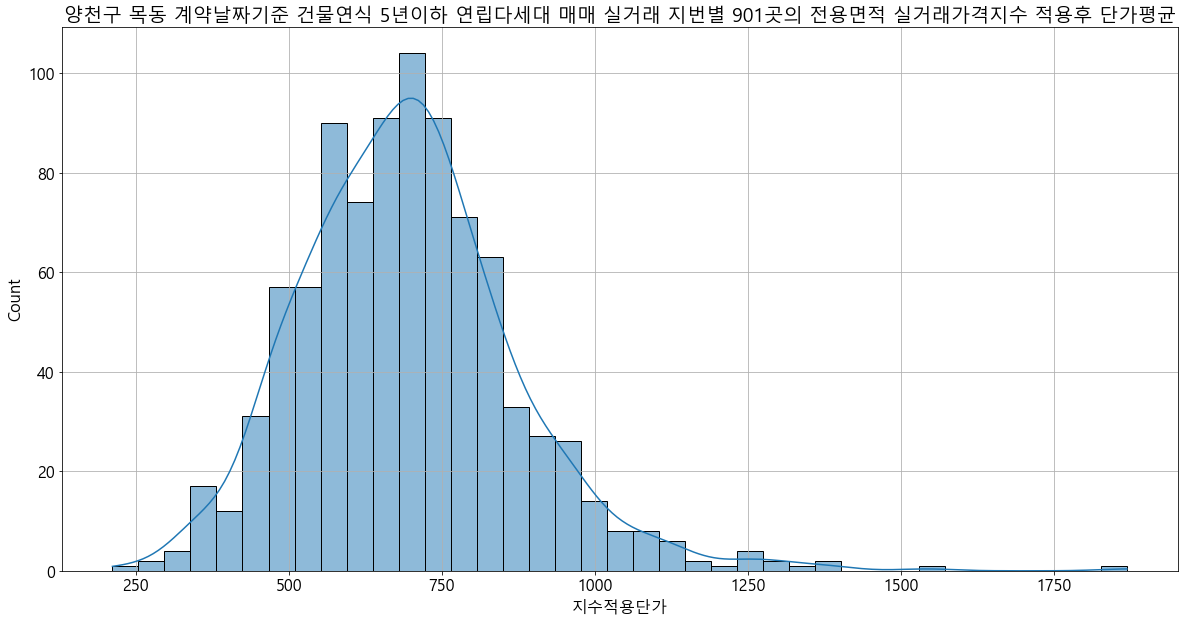

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 양천구 목동 124-10,에스엘파크뷰,2015.0,42.37,2020-10-22,654.708520,2021-03-01,690.283988,제2종일반주거지역,연립다세대
1,서울특별시 양천구 목동 124-11,일주하우스,2018.0,29.66,2018-11-26,886.716116,2021-03-01,1060.340152,제2종일반주거지역,연립다세대
2,서울특별시 양천구 목동 124-15,화이트빌,2002.0,60.42,2006-11-24,413.770275,2021-03-01,804.957034,제2종일반주거지역,연립다세대
3,서울특별시 양천구 목동 124-18,아줄리움,2014.0,31.56,2018-11-28,697.084918,2021-03-01,833.578091,제2종일반주거지역,연립다세대
4,서울특별시 양천구 목동 124-19,목동리치하우스,2012.0,42.37,2012-11-11,590.040123,2021-03-01,865.785402,제2종일반주거지역,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)